## Load Data Set

In [1]:
import zipfile
import os
import numpy as np
import pathlib
import pandas as pd
from math import ceil
import tensorflow as tf
import numpy as np
import IPython.display as display
import keras
from keras import backend as K
from matplotlib import pyplot as plt
from keras.utils import to_categorical


print(tf.__version__)


mnist = keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Using TensorFlow backend.


1.13.1


In [2]:
print(x_train.shape, y_train.shape)
x_train = np.expand_dims(x_train, -1)
y_train = to_categorical(y_train)
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (60000, 10)


In [3]:
def custom_loader():
  BATCH_SIZE = 32

  trainset_size = x_train.shape[0]

  p = 0
  while True:

    idx_from = (p * BATCH_SIZE) % trainset_size

    idx_to = idx_from + BATCH_SIZE

    batch_x = x_train[idx_from: idx_to]
    batch_y = y_train[idx_from: idx_to]
    
    p += 1
  
    yield batch_x, batch_y

In [4]:
custom_gen = custom_loader()
for i in range(3):
  batch_x, batch_y = next(custom_gen)
  print(batch_x.shape, batch_y.shape)

(32, 28, 28, 1) (32, 10)
(32, 28, 28, 1) (32, 10)
(32, 28, 28, 1) (32, 10)


## Model Design

In [5]:
enc_len = 0
age_len = 10
img_shape = (28, 28, 1)
width, height, depth = (28, 28, 1)
img_len = np.prod(img_shape)
latent_dim = enc_len + age_len + img_len
noise_len = 50  # 32 x 32 x 3
input_dim = enc_len + age_len + noise_len
cond_len = enc_len + age_len


def build_discriminator():
    conv = keras.Sequential([
        # conv block 1
        keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=2,
            input_shape=img_shape
        ),
        keras.layers.Activation(tf.nn.relu),

        # conv block 2
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=2
        ),
        keras.layers.Activation(tf.nn.relu),
        
        # conv block 3
        keras.layers.Conv2D(
            filters=3,
            kernel_size=(3, 3),
            strides=2
        ),
        keras.layers.Activation(tf.nn.relu),
    ])
    
    conv.summary()
    
    model = keras.Sequential([
        # dense 1
        keras.layers.Dense(16, input_shape=(22,)),
        keras.layers.Activation(tf.nn.relu),
        
        # output
        keras.layers.Dense(1),
        keras.layers.Activation(tf.nn.sigmoid),
    ])
    
    model.summary()
    
    # condition
#     c1 = keras.layers.Input(shape=(enc_len,))
    c2 = keras.layers.Input(shape=(age_len,))
    
    # image
    z = keras.layers.Input(shape=img_shape)
    
    # convolution
    zout = conv(z)
    
    # flatten image
    z_flat = keras.layers.Flatten()(zout)
    
    # concatenation
    inputs = keras.layers.concatenate([c2, z_flat])
    
    # real or fake
    outputs = model(inputs)
    
    return keras.models.Model([c2, z], outputs)


def build_generator():
    
    conv = keras.Sequential([
        # transpose conv block 1
        keras.layers.Conv2DTranspose(
            filters=16,
            kernel_size=(3, 3),
            strides=1,
            input_shape=(10, 10, 1)
        ),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.UpSampling2D(size=(2, 2)),
        
        # transpose conv block 1
        keras.layers.Conv2DTranspose(
            filters=8,
            kernel_size=(3, 3),
            strides=1
        ),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.UpSampling2D(size=(1, 1)),

        # transpose conv block 2
        keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=(3, 3),
            strides=1
        ),
        
        # output
        keras.layers.Activation(tf.nn.tanh)
    ])
    
    conv.summary()
    
    model = keras.Sequential([
        # dense 1
        keras.layers.Dense(100, input_shape=(input_dim,)),
        keras.layers.Activation(tf.nn.relu),
        
        # reshape 1d to 3d
        keras.layers.Reshape((10, 10, 1))
    ])
    
    model.summary()
    
    # condition
#     c1 = keras.layers.Input(shape=(enc_len,))
    c2 = keras.layers.Input(shape=(age_len,))
    
    # noise
    x = keras.layers.Input(shape=(noise_len,))

    # concatenation
    inputs = keras.layers.concatenate([c2, x])
    
    # flat dense output
    out_1 = model(inputs)
    
    # transpose conv output
    outputs = conv(out_1)
    
    return keras.models.Model([c2, x], outputs)


discriminator = build_discriminator()
generator = build_generator()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 13, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 3)           867       
_________________________________________________________________
activation_3 (Activation)    (None, 2, 2, 3)           0         
Total params: 5,667
Trainable params: 5,667
Non-trainable params: 0
__

In [6]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 60)           0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 10, 10, 1)    6100        concatenate_2[0][0]              
__________

In [7]:
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2, 2, 3)      5667        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 12)           0           sequential_1[1][0]               
__________________________________________________________________________________________________
concatenat

## Generative Adversarial Network

In [8]:
GLR = 0.0002  # generator
DLR = 0.0002  # discriminator


discriminator.compile(
    optimizer=keras.optimizers.Adam(DLR, 0.5),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy']
)


# condition
# c1 = keras.layers.Input(shape=(enc_len,))
c2 = keras.layers.Input(shape=(age_len,))

# noise
x = keras.layers.Input(shape=(noise_len,))

# freeze discriminator
discriminator.trainable = False

# output
z = generator([c2, x])
out = discriminator([c2, z])

# GAN
gan = keras.models.Model(inputs=[c2, x], outputs=out)

gan.compile(
    optimizer=keras.optimizers.Adam(GLR , 0.5),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy'])

In [9]:
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28, 1)    7493        input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            6052        input_5[0][0]                    
          

## Visualization Method

In [10]:
# from google.colab import drive
import os


# drive.mount('/content/gdrive', force_remount=True)

root_path = './'
tgt_pth = os.path.join(root_path, 'visualize_mnist-v17')

if not os.path.exists(tgt_pth):
  os.mkdir(tgt_pth)

In [11]:
def visualizeGAN(e, z_real, z_fake):

    fig, axes = plt.subplots(8, 8, figsize=(40, 36))

    r_real = 0
    r_fake = 0
    for row, axe in enumerate(axes):
        for col, cell in enumerate(axe):
            if row % 2 == 0:
                cell.imshow(z_real[r_real * 8 + col])
            else:
                cell.imshow(z_fake[r_fake * 8 + col])

            cell.axis("off")

        if row % 2 == 0:
            r_real += 1
        else:
            r_fake += 1

    plt.axis("off")
    
    fig.savefig(os.path.join(tgt_pth, '{}.jpg'.format(str(e).zfill(3))))
    
    plt.close()

## Load Batch

In [12]:
def load_noise():
    
    y_true = tf.ones((BATCH_SIZE,))
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.40

    with tf.Session(config=config) as sess:
        tf.initialize_all_variables().run()
        
        # run once
        y_true = y_true.eval()

        while True:
            batch_x, batch_y = next(custom_gen)

            sz = batch_x.shape[0]

            if sz != BATCH_SIZE:
                continue
            
            # fake data
            c2 = tf.cast(batch_y, tf.float32).eval()
            x = tf.random.normal((sz, noise_len,)).eval()
            
            yield c2, x, y_true


def load_batch():
    
    y_fake = tf.zeros((BATCH_SIZE,))
    y_true = tf.ones((BATCH_SIZE,))
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.40

    with tf.Session(config=config) as sess:
        tf.initialize_all_variables().run()
        
        # run once
        y_fake = y_fake.eval()
        y_true = y_true.eval()

        while True:
            batch_x, batch_y = next(custom_gen)

            sz = batch_x.shape[0]

            if sz != BATCH_SIZE:
                continue
            
            # fake data
            c2 = tf.cast(batch_y, tf.float32).eval()
            x = tf.random.normal((sz, noise_len,)).eval()
            z_fake = generator.predict([c2, x])

            # real data
            c2 = tf.cast(batch_y, tf.float32).eval()
            z_real = batch_x
                        
            yield c2, x, z_fake, y_fake, z_real, y_true

## Train Model

In [13]:
BATCH_SIZE = 32
EPOCHS = 2000
STEPS = 1  # 60000 // BATCH_SIZE


train_loss_g = []
train_loss_d = []

train_acc_g = []
train_acc_d = []


disc_itr = load_batch()
gen_itr = load_noise()


# epochs
for e in range(EPOCHS):

    #batches
    loss = []
    acc = []

    for p in range(STEPS * 4):
        
        c2, x, z_fake, y_fake, z_real, y_real = next(disc_itr)
    
        # train
        loss_2, acc_2 = discriminator.train_on_batch([c2, z_real], y_real)
        loss_1, acc_1 = discriminator.train_on_batch([c2, z_fake], y_fake)

        batch_loss = 0.5 * (loss_1 + loss_2)
        batch_acc = 0.5 * (acc_1 + acc_2)

        loss.append(batch_loss)
        acc.append(batch_acc)

    train_loss_d.append(np.mean(np.array(loss)))
    train_acc_d.append(np.mean(np.array(acc)))

    #batches
    loss = []
    acc = []

    for p in range(STEPS):

      c2, x, y_true = next(gen_itr)

      # train
      loss_1, acc_1 = gan.train_on_batch([c2, x], y_true)

      loss.append(loss_1)
      acc.append(acc_1)

    train_loss_g.append(np.mean(np.array(loss)))
    train_acc_g.append(np.mean(np.array(acc)))


    print("Epoch: {}, Steps: {}, Discriminator Accuracy: %{:.2f}, GAN Accuracy: %{:.2f}".format(
          e,
          STEPS,
          train_acc_d[-1] * 100,
          train_acc_g[-1] * 100
      ))

    if e % 100 == 0:
        ## visualize results
        batch_x, batch_y = next(custom_gen)

        sz = batch_x.shape[0]

        # fake data
        #     c1 = row['enc']
        c2 = tf.cast(batch_y, tf.float32).eval()
        x = tf.random.normal((sz, noise_len,)).eval()
        z_fake = generator.predict([c2, x])
        z_fake = np.squeeze(z_fake, axis=-1)

        # real data
        z_real = batch_x
        z_real = np.squeeze(z_real, axis=-1)

        visualizeGAN(e, z_real, z_fake)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, Steps: 1, Discriminator Accuracy: %50.39, GAN Accuracy: %28.12
Epoch: 1, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %15.62
Epoch: 2, Steps: 1, Discriminator Accuracy: %50.00, GAN Accuracy: %9.38
Epoch: 3, Steps: 1, Discriminator Accuracy: %51.17, GAN Accuracy: %28.12
Epoch: 4, Steps: 1, Discriminator Accuracy: %53.91, GAN Accuracy: %12.50
Epoch: 5, Steps: 1, Discriminator Accuracy: %54.30, GAN Accuracy: %21.88
Epoch: 6, Steps: 1, Discriminator Accuracy: %56.25, GAN Accuracy: %37.50
Epoch: 7, Steps: 1, Discriminator Accuracy: %59.77, GAN Accuracy: %12.50
Epoch: 8, Steps: 1, Discriminator Accuracy: %61.33, GAN Accuracy: %15.62
Epoch: 9, Steps: 1, Discriminator Accuracy: %61.33, GAN Accuracy: %12.50
Epoch: 10, Steps: 1, Discriminator Accuracy: %67.19, GAN Accuracy: %21.88
Epoch: 11, Steps: 1, Discriminator Accuracy: %73.83, GAN Accuracy: %21.88
Epoch: 12, Steps: 1, Discriminator Accuracy: %71.09, GAN Accuracy: %21.88
Epoch: 13, Steps: 1, Discriminator Accuracy: %79.

Epoch: 112, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 113, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 114, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 115, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 116, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 117, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 118, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 119, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 120, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 121, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 122, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 123, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 124, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 125, Steps: 1, Discrim

Epoch: 223, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 224, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 225, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 226, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %3.12
Epoch: 227, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 228, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 229, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 230, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 231, Steps: 1, Discriminator Accuracy: %98.83, GAN Accuracy: %0.00
Epoch: 232, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 233, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 234, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 235, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 236, Steps: 1, Discriminato

Epoch: 334, Steps: 1, Discriminator Accuracy: %98.44, GAN Accuracy: %0.00
Epoch: 335, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 336, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 337, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 338, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 339, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 340, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 341, Steps: 1, Discriminator Accuracy: %99.61, GAN Accuracy: %0.00
Epoch: 342, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 343, Steps: 1, Discriminator Accuracy: %100.00, GAN Accuracy: %0.00
Epoch: 344, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 345, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 346, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 347, Steps: 1, Discriminator A

Epoch: 445, Steps: 1, Discriminator Accuracy: %97.27, GAN Accuracy: %0.00
Epoch: 446, Steps: 1, Discriminator Accuracy: %97.27, GAN Accuracy: %0.00
Epoch: 447, Steps: 1, Discriminator Accuracy: %96.09, GAN Accuracy: %3.12
Epoch: 448, Steps: 1, Discriminator Accuracy: %97.27, GAN Accuracy: %0.00
Epoch: 449, Steps: 1, Discriminator Accuracy: %97.66, GAN Accuracy: %0.00
Epoch: 450, Steps: 1, Discriminator Accuracy: %97.27, GAN Accuracy: %0.00
Epoch: 451, Steps: 1, Discriminator Accuracy: %96.88, GAN Accuracy: %0.00
Epoch: 452, Steps: 1, Discriminator Accuracy: %97.27, GAN Accuracy: %9.38
Epoch: 453, Steps: 1, Discriminator Accuracy: %94.92, GAN Accuracy: %0.00
Epoch: 454, Steps: 1, Discriminator Accuracy: %97.66, GAN Accuracy: %3.12
Epoch: 455, Steps: 1, Discriminator Accuracy: %99.22, GAN Accuracy: %0.00
Epoch: 456, Steps: 1, Discriminator Accuracy: %94.92, GAN Accuracy: %0.00
Epoch: 457, Steps: 1, Discriminator Accuracy: %98.05, GAN Accuracy: %0.00
Epoch: 458, Steps: 1, Discriminator Ac

Epoch: 556, Steps: 1, Discriminator Accuracy: %93.36, GAN Accuracy: %9.38
Epoch: 557, Steps: 1, Discriminator Accuracy: %96.09, GAN Accuracy: %0.00
Epoch: 558, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %3.12
Epoch: 559, Steps: 1, Discriminator Accuracy: %92.19, GAN Accuracy: %6.25
Epoch: 560, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %6.25
Epoch: 561, Steps: 1, Discriminator Accuracy: %90.23, GAN Accuracy: %15.62
Epoch: 562, Steps: 1, Discriminator Accuracy: %94.53, GAN Accuracy: %3.12
Epoch: 563, Steps: 1, Discriminator Accuracy: %92.97, GAN Accuracy: %6.25
Epoch: 564, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %3.12
Epoch: 565, Steps: 1, Discriminator Accuracy: %93.75, GAN Accuracy: %3.12
Epoch: 566, Steps: 1, Discriminator Accuracy: %90.62, GAN Accuracy: %0.00
Epoch: 567, Steps: 1, Discriminator Accuracy: %92.58, GAN Accuracy: %0.00
Epoch: 568, Steps: 1, Discriminator Accuracy: %93.75, GAN Accuracy: %3.12
Epoch: 569, Steps: 1, Discriminator A

Epoch: 667, Steps: 1, Discriminator Accuracy: %94.14, GAN Accuracy: %9.38
Epoch: 668, Steps: 1, Discriminator Accuracy: %85.16, GAN Accuracy: %3.12
Epoch: 669, Steps: 1, Discriminator Accuracy: %87.11, GAN Accuracy: %3.12
Epoch: 670, Steps: 1, Discriminator Accuracy: %87.89, GAN Accuracy: %6.25
Epoch: 671, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %3.12
Epoch: 672, Steps: 1, Discriminator Accuracy: %87.89, GAN Accuracy: %3.12
Epoch: 673, Steps: 1, Discriminator Accuracy: %86.72, GAN Accuracy: %6.25
Epoch: 674, Steps: 1, Discriminator Accuracy: %89.45, GAN Accuracy: %9.38
Epoch: 675, Steps: 1, Discriminator Accuracy: %89.45, GAN Accuracy: %0.00
Epoch: 676, Steps: 1, Discriminator Accuracy: %89.45, GAN Accuracy: %0.00
Epoch: 677, Steps: 1, Discriminator Accuracy: %90.62, GAN Accuracy: %9.38
Epoch: 678, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %6.25
Epoch: 679, Steps: 1, Discriminator Accuracy: %87.50, GAN Accuracy: %6.25
Epoch: 680, Steps: 1, Discriminator Ac

Epoch: 778, Steps: 1, Discriminator Accuracy: %91.41, GAN Accuracy: %0.00
Epoch: 779, Steps: 1, Discriminator Accuracy: %90.23, GAN Accuracy: %0.00
Epoch: 780, Steps: 1, Discriminator Accuracy: %93.36, GAN Accuracy: %6.25
Epoch: 781, Steps: 1, Discriminator Accuracy: %88.67, GAN Accuracy: %9.38
Epoch: 782, Steps: 1, Discriminator Accuracy: %92.97, GAN Accuracy: %9.38
Epoch: 783, Steps: 1, Discriminator Accuracy: %90.62, GAN Accuracy: %6.25
Epoch: 784, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %3.12
Epoch: 785, Steps: 1, Discriminator Accuracy: %87.50, GAN Accuracy: %6.25
Epoch: 786, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %0.00
Epoch: 787, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %3.12
Epoch: 788, Steps: 1, Discriminator Accuracy: %84.77, GAN Accuracy: %0.00
Epoch: 789, Steps: 1, Discriminator Accuracy: %92.97, GAN Accuracy: %3.12
Epoch: 790, Steps: 1, Discriminator Accuracy: %84.38, GAN Accuracy: %6.25
Epoch: 791, Steps: 1, Discriminator Ac

Epoch: 889, Steps: 1, Discriminator Accuracy: %78.52, GAN Accuracy: %6.25
Epoch: 890, Steps: 1, Discriminator Accuracy: %86.72, GAN Accuracy: %3.12
Epoch: 891, Steps: 1, Discriminator Accuracy: %89.45, GAN Accuracy: %18.75
Epoch: 892, Steps: 1, Discriminator Accuracy: %90.62, GAN Accuracy: %9.38
Epoch: 893, Steps: 1, Discriminator Accuracy: %87.11, GAN Accuracy: %12.50
Epoch: 894, Steps: 1, Discriminator Accuracy: %92.58, GAN Accuracy: %9.38
Epoch: 895, Steps: 1, Discriminator Accuracy: %87.89, GAN Accuracy: %9.38
Epoch: 896, Steps: 1, Discriminator Accuracy: %88.67, GAN Accuracy: %6.25
Epoch: 897, Steps: 1, Discriminator Accuracy: %90.23, GAN Accuracy: %0.00
Epoch: 898, Steps: 1, Discriminator Accuracy: %89.45, GAN Accuracy: %9.38
Epoch: 899, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %9.38
Epoch: 900, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %0.00
Epoch: 901, Steps: 1, Discriminator Accuracy: %84.38, GAN Accuracy: %18.75
Epoch: 902, Steps: 1, Discriminator

Epoch: 1000, Steps: 1, Discriminator Accuracy: %76.95, GAN Accuracy: %3.12
Epoch: 1001, Steps: 1, Discriminator Accuracy: %90.23, GAN Accuracy: %6.25
Epoch: 1002, Steps: 1, Discriminator Accuracy: %93.36, GAN Accuracy: %6.25
Epoch: 1003, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %3.12
Epoch: 1004, Steps: 1, Discriminator Accuracy: %81.64, GAN Accuracy: %3.12
Epoch: 1005, Steps: 1, Discriminator Accuracy: %78.91, GAN Accuracy: %18.75
Epoch: 1006, Steps: 1, Discriminator Accuracy: %80.86, GAN Accuracy: %25.00
Epoch: 1007, Steps: 1, Discriminator Accuracy: %83.59, GAN Accuracy: %6.25
Epoch: 1008, Steps: 1, Discriminator Accuracy: %83.59, GAN Accuracy: %9.38
Epoch: 1009, Steps: 1, Discriminator Accuracy: %83.20, GAN Accuracy: %9.38
Epoch: 1010, Steps: 1, Discriminator Accuracy: %80.08, GAN Accuracy: %3.12
Epoch: 1011, Steps: 1, Discriminator Accuracy: %81.64, GAN Accuracy: %9.38
Epoch: 1012, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %9.38
Epoch: 1013, Steps: 1, 

Epoch: 1110, Steps: 1, Discriminator Accuracy: %87.89, GAN Accuracy: %3.12
Epoch: 1111, Steps: 1, Discriminator Accuracy: %85.55, GAN Accuracy: %12.50
Epoch: 1112, Steps: 1, Discriminator Accuracy: %91.41, GAN Accuracy: %3.12
Epoch: 1113, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %9.38
Epoch: 1114, Steps: 1, Discriminator Accuracy: %90.62, GAN Accuracy: %9.38
Epoch: 1115, Steps: 1, Discriminator Accuracy: %93.75, GAN Accuracy: %15.62
Epoch: 1116, Steps: 1, Discriminator Accuracy: %91.41, GAN Accuracy: %0.00
Epoch: 1117, Steps: 1, Discriminator Accuracy: %91.02, GAN Accuracy: %6.25
Epoch: 1118, Steps: 1, Discriminator Accuracy: %66.80, GAN Accuracy: %18.75
Epoch: 1119, Steps: 1, Discriminator Accuracy: %92.58, GAN Accuracy: %9.38
Epoch: 1120, Steps: 1, Discriminator Accuracy: %86.33, GAN Accuracy: %3.12
Epoch: 1121, Steps: 1, Discriminator Accuracy: %84.38, GAN Accuracy: %18.75
Epoch: 1122, Steps: 1, Discriminator Accuracy: %87.89, GAN Accuracy: %6.25
Epoch: 1123, Steps: 1

Epoch: 1219, Steps: 1, Discriminator Accuracy: %90.23, GAN Accuracy: %12.50
Epoch: 1220, Steps: 1, Discriminator Accuracy: %86.33, GAN Accuracy: %3.12
Epoch: 1221, Steps: 1, Discriminator Accuracy: %84.77, GAN Accuracy: %12.50
Epoch: 1222, Steps: 1, Discriminator Accuracy: %86.33, GAN Accuracy: %18.75
Epoch: 1223, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %6.25
Epoch: 1224, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %3.12
Epoch: 1225, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %3.12
Epoch: 1226, Steps: 1, Discriminator Accuracy: %86.33, GAN Accuracy: %6.25
Epoch: 1227, Steps: 1, Discriminator Accuracy: %86.72, GAN Accuracy: %9.38
Epoch: 1228, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %0.00
Epoch: 1229, Steps: 1, Discriminator Accuracy: %84.38, GAN Accuracy: %6.25
Epoch: 1230, Steps: 1, Discriminator Accuracy: %84.77, GAN Accuracy: %9.38
Epoch: 1231, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %9.38
Epoch: 1232, Steps: 1,

Epoch: 1328, Steps: 1, Discriminator Accuracy: %84.38, GAN Accuracy: %9.38
Epoch: 1329, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %3.12
Epoch: 1330, Steps: 1, Discriminator Accuracy: %87.50, GAN Accuracy: %0.00
Epoch: 1331, Steps: 1, Discriminator Accuracy: %90.62, GAN Accuracy: %6.25
Epoch: 1332, Steps: 1, Discriminator Accuracy: %82.03, GAN Accuracy: %9.38
Epoch: 1333, Steps: 1, Discriminator Accuracy: %87.50, GAN Accuracy: %0.00
Epoch: 1334, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %3.12
Epoch: 1335, Steps: 1, Discriminator Accuracy: %92.97, GAN Accuracy: %9.38
Epoch: 1336, Steps: 1, Discriminator Accuracy: %90.23, GAN Accuracy: %6.25
Epoch: 1337, Steps: 1, Discriminator Accuracy: %94.14, GAN Accuracy: %3.12
Epoch: 1338, Steps: 1, Discriminator Accuracy: %81.64, GAN Accuracy: %9.38
Epoch: 1339, Steps: 1, Discriminator Accuracy: %83.20, GAN Accuracy: %3.12
Epoch: 1340, Steps: 1, Discriminator Accuracy: %86.33, GAN Accuracy: %18.75
Epoch: 1341, Steps: 1, D

Epoch: 1437, Steps: 1, Discriminator Accuracy: %87.50, GAN Accuracy: %9.38
Epoch: 1438, Steps: 1, Discriminator Accuracy: %91.02, GAN Accuracy: %12.50
Epoch: 1439, Steps: 1, Discriminator Accuracy: %89.45, GAN Accuracy: %12.50
Epoch: 1440, Steps: 1, Discriminator Accuracy: %88.67, GAN Accuracy: %0.00
Epoch: 1441, Steps: 1, Discriminator Accuracy: %73.44, GAN Accuracy: %0.00
Epoch: 1442, Steps: 1, Discriminator Accuracy: %86.72, GAN Accuracy: %0.00
Epoch: 1443, Steps: 1, Discriminator Accuracy: %87.89, GAN Accuracy: %6.25
Epoch: 1444, Steps: 1, Discriminator Accuracy: %83.59, GAN Accuracy: %12.50
Epoch: 1445, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %3.12
Epoch: 1446, Steps: 1, Discriminator Accuracy: %87.11, GAN Accuracy: %6.25
Epoch: 1447, Steps: 1, Discriminator Accuracy: %85.55, GAN Accuracy: %9.38
Epoch: 1448, Steps: 1, Discriminator Accuracy: %90.62, GAN Accuracy: %3.12
Epoch: 1449, Steps: 1, Discriminator Accuracy: %85.94, GAN Accuracy: %6.25
Epoch: 1450, Steps: 1,

Epoch: 1546, Steps: 1, Discriminator Accuracy: %83.98, GAN Accuracy: %12.50
Epoch: 1547, Steps: 1, Discriminator Accuracy: %87.11, GAN Accuracy: %6.25
Epoch: 1548, Steps: 1, Discriminator Accuracy: %85.16, GAN Accuracy: %6.25
Epoch: 1549, Steps: 1, Discriminator Accuracy: %76.17, GAN Accuracy: %12.50
Epoch: 1550, Steps: 1, Discriminator Accuracy: %82.81, GAN Accuracy: %3.12
Epoch: 1551, Steps: 1, Discriminator Accuracy: %88.28, GAN Accuracy: %3.12
Epoch: 1552, Steps: 1, Discriminator Accuracy: %92.58, GAN Accuracy: %6.25
Epoch: 1553, Steps: 1, Discriminator Accuracy: %90.62, GAN Accuracy: %0.00
Epoch: 1554, Steps: 1, Discriminator Accuracy: %85.16, GAN Accuracy: %0.00
Epoch: 1555, Steps: 1, Discriminator Accuracy: %85.94, GAN Accuracy: %21.88
Epoch: 1556, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %12.50
Epoch: 1557, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %3.12
Epoch: 1558, Steps: 1, Discriminator Accuracy: %92.97, GAN Accuracy: %9.38
Epoch: 1559, Steps: 1

Epoch: 1655, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %3.12
Epoch: 1656, Steps: 1, Discriminator Accuracy: %88.67, GAN Accuracy: %3.12
Epoch: 1657, Steps: 1, Discriminator Accuracy: %90.23, GAN Accuracy: %9.38
Epoch: 1658, Steps: 1, Discriminator Accuracy: %87.11, GAN Accuracy: %6.25
Epoch: 1659, Steps: 1, Discriminator Accuracy: %87.11, GAN Accuracy: %6.25
Epoch: 1660, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %6.25
Epoch: 1661, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %6.25
Epoch: 1662, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %6.25
Epoch: 1663, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %9.38
Epoch: 1664, Steps: 1, Discriminator Accuracy: %85.94, GAN Accuracy: %0.00
Epoch: 1665, Steps: 1, Discriminator Accuracy: %85.55, GAN Accuracy: %6.25
Epoch: 1666, Steps: 1, Discriminator Accuracy: %87.50, GAN Accuracy: %3.12
Epoch: 1667, Steps: 1, Discriminator Accuracy: %92.97, GAN Accuracy: %0.00
Epoch: 1668, Steps: 1, Di

Epoch: 1765, Steps: 1, Discriminator Accuracy: %89.45, GAN Accuracy: %3.12
Epoch: 1766, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %9.38
Epoch: 1767, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %9.38
Epoch: 1768, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %9.38
Epoch: 1769, Steps: 1, Discriminator Accuracy: %87.11, GAN Accuracy: %12.50
Epoch: 1770, Steps: 1, Discriminator Accuracy: %90.62, GAN Accuracy: %6.25
Epoch: 1771, Steps: 1, Discriminator Accuracy: %91.41, GAN Accuracy: %15.62
Epoch: 1772, Steps: 1, Discriminator Accuracy: %83.59, GAN Accuracy: %0.00
Epoch: 1773, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %15.62
Epoch: 1774, Steps: 1, Discriminator Accuracy: %94.14, GAN Accuracy: %0.00
Epoch: 1775, Steps: 1, Discriminator Accuracy: %92.58, GAN Accuracy: %0.00
Epoch: 1776, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %6.25
Epoch: 1777, Steps: 1, Discriminator Accuracy: %87.11, GAN Accuracy: %9.38
Epoch: 1778, Steps: 1,

Epoch: 1874, Steps: 1, Discriminator Accuracy: %85.16, GAN Accuracy: %3.12
Epoch: 1875, Steps: 1, Discriminator Accuracy: %87.89, GAN Accuracy: %3.12
Epoch: 1876, Steps: 1, Discriminator Accuracy: %88.28, GAN Accuracy: %6.25
Epoch: 1877, Steps: 1, Discriminator Accuracy: %85.55, GAN Accuracy: %0.00
Epoch: 1878, Steps: 1, Discriminator Accuracy: %73.05, GAN Accuracy: %12.50
Epoch: 1879, Steps: 1, Discriminator Accuracy: %79.69, GAN Accuracy: %6.25
Epoch: 1880, Steps: 1, Discriminator Accuracy: %88.28, GAN Accuracy: %6.25
Epoch: 1881, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %3.12
Epoch: 1882, Steps: 1, Discriminator Accuracy: %83.98, GAN Accuracy: %9.38
Epoch: 1883, Steps: 1, Discriminator Accuracy: %83.98, GAN Accuracy: %0.00
Epoch: 1884, Steps: 1, Discriminator Accuracy: %92.19, GAN Accuracy: %3.12
Epoch: 1885, Steps: 1, Discriminator Accuracy: %88.28, GAN Accuracy: %3.12
Epoch: 1886, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %6.25
Epoch: 1887, Steps: 1, D

Epoch: 1984, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %3.12
Epoch: 1985, Steps: 1, Discriminator Accuracy: %89.84, GAN Accuracy: %6.25
Epoch: 1986, Steps: 1, Discriminator Accuracy: %91.02, GAN Accuracy: %9.38
Epoch: 1987, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %0.00
Epoch: 1988, Steps: 1, Discriminator Accuracy: %91.80, GAN Accuracy: %3.12
Epoch: 1989, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %3.12
Epoch: 1990, Steps: 1, Discriminator Accuracy: %83.98, GAN Accuracy: %9.38
Epoch: 1991, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %6.25
Epoch: 1992, Steps: 1, Discriminator Accuracy: %79.69, GAN Accuracy: %6.25
Epoch: 1993, Steps: 1, Discriminator Accuracy: %88.28, GAN Accuracy: %9.38
Epoch: 1994, Steps: 1, Discriminator Accuracy: %91.41, GAN Accuracy: %3.12
Epoch: 1995, Steps: 1, Discriminator Accuracy: %92.58, GAN Accuracy: %3.12
Epoch: 1996, Steps: 1, Discriminator Accuracy: %89.06, GAN Accuracy: %0.00
Epoch: 1997, Steps: 1, Di

## Plot Loss

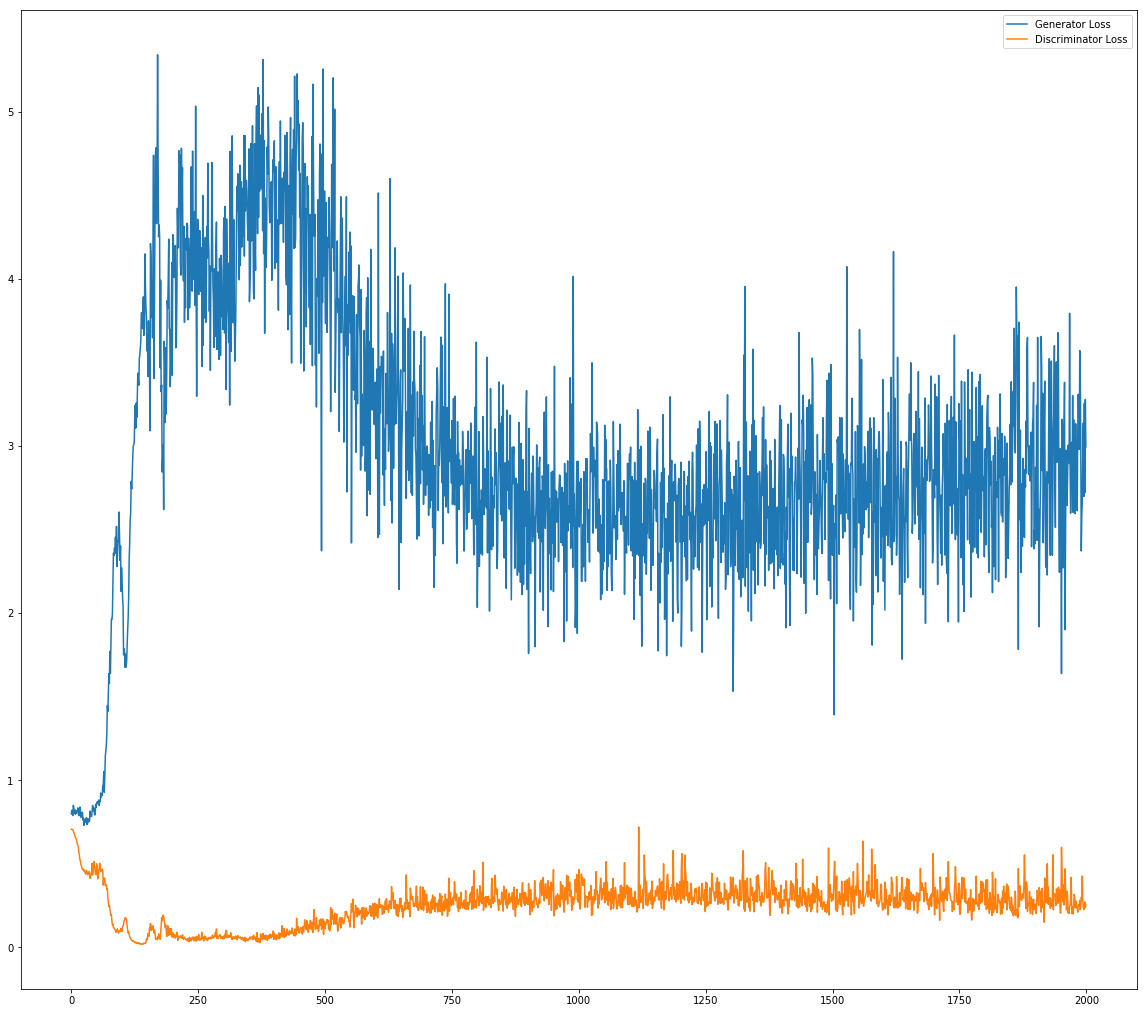

In [14]:
plt.figure(figsize=(20, 18))
plt.plot(train_loss_g, label="Generator Loss");
plt.plot(train_loss_d, label="Discriminator Loss");
plt.legend();

## Plot Accuracy

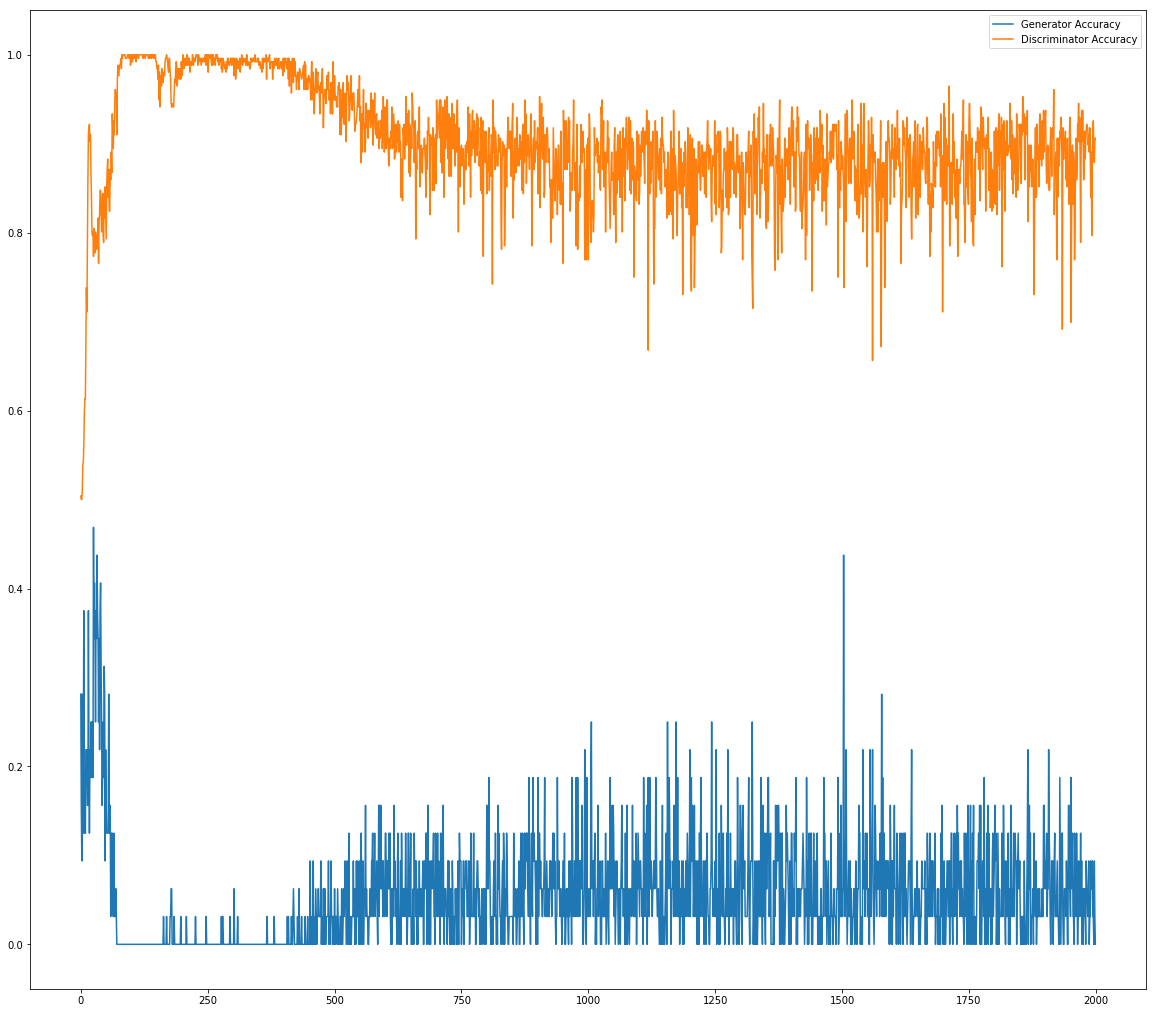

In [15]:
plt.figure(figsize=(20, 18))
plt.plot(train_acc_g, label="Generator Accuracy");
plt.plot(train_acc_d, label="Discriminator Accuracy");
plt.legend();

In [16]:
generator.save('./mnist-gen.h5')

In [17]:
discriminator.save('./mnist-disc.h5')

In [18]:
gan.save('./mnist-gan.h5')